In [1]:
import csv
from pathlib import Path
import matplotlib.pyplot as plot
import re

import nltk

# nltk.download('book')
# nltk.download('brown')

from nltk.corpus import brown
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer

import gensim
from gensim import corpora, models
import numpy as np
np.random.seed(2018)

CROWD_RE_REQUIREMENTS = Path('..', 'crowdre_cleaned-csv', 'requirements.csv')

In [2]:
class Requirement(object):
    def __init__(self, text):
        self.text = text
    
    def tokenize(self):
        self.tokens = nltk.word_tokenize(self.cleaned_text)
    
    def redundant_start(self):
        self.starts_with_smart_home = "I want my smart home to".lower() in self.text.lower()
    
    def remove_stopwords(self):
        self.lexical_words = [word for word in self.tokens if word not in stopwords.words('english')]
        
    def reduce_to_stem(self):
        #lancasterStemmer = LancasterStemmer()
        porterStemmer = PorterStemmer()
        self.stems = []
        for lexicalWord in self.lexical_words:
            self.stems.append(porterStemmer.stem(lexicalWord))
            
    def remove_special_characters(self):
        regexOnlyWords = r'([A-Za-z]*)'
        self.cleaned_text = ' '.join(re.findall(regexOnlyWords,self.text))
        
    def complete_analysis(self):
        self.remove_special_characters()
        self.tokenize()
        self.redundant_start()
        self.remove_stopwords()
        self.reduce_to_stem()
    
    def __str__(self):
        return self.text

In [3]:
class RequirementsList(object):
    def __init__(self, path):
        if not path.exists() and path.is_file():
            raise("The given path does not exist or is not a file.")
        self._build_requirements_list(path)
        self._order_the_tags_list()
    
    def __iter__(self):
        return self.requirements.__iter__() if hasattr(self, 'requirements') else []

    def _build_requirements_list(self, path):
        self.requirements = []
        self.tags = dict()
        self.tagNum = []
        with open(path, newline='') as requirements_csv:
            re_reader = csv.DictReader(requirements_csv, delimiter=',')
            for row in re_reader:
                requirementText = "As a " + row['role'] + " I want " + row['feature'] + " so that " + row['benefit']
                # Get the list of tags
                tagsList = row['tags'].split(",")
                # Remove the whitespaces
                tagsList = [tag.strip(' ') for tag in tagsList]
                # Remove space elements
                tagsList = [tag for tag in tagsList if tag != " "]
                tagsList = [tag for tag in tagsList if tag != ""]
                # Store the counter of tags in a map
                self.tagNum.append(len(tagsList))
                for tag in tagsList:
                    if tag not in self.tags.keys():
                        self.tags[tag] = 1
                    else:
                        self.tags[tag] = self.tags[tag] + 1
                requirement = Requirement(requirementText)
                self.requirements.append(requirement)
                
    def _order_the_tags_list(self):
        orderedDict = dict()
        for key in sorted(self.tags, key=self.tags.get, reverse=True):
            orderedDict[key] = self.tags[key]
        self.tags = orderedDict

    def count(self):
        return len(self.requirements) if hasattr(self, 'requirements') else 0

re_list = RequirementsList(CROWD_RE_REQUIREMENTS)

In [4]:
# NLP analysis
joined_text = " ".join(map(lambda re: re.text, re_list.requirements))
joined_text_tokenized = nltk.word_tokenize(joined_text)

no_of_requirements = re_list.count()
tokens = []
lexical_words = []
stems = []
re_starting_with_smart_home = 0

lexical_words = []

for requirement in re_list:
    requirement.complete_analysis()
    tokens += requirement.tokens    
    lexical_words += requirement.lexical_words
    stems += requirement.stems
    if requirement.starts_with_smart_home:
        re_starting_with_smart_home += 1 

In [5]:
print("Number of Tokens (unique): \t\t{} ({})".format(len(tokens), len(set(tokens))))
print("Number of Lexical Words: \t\t{}".format(len(lexical_words)))

print("\nVocabulary Size (Lexical Words): \t{}".format(len(set(lexical_words))))
print("Vocabulary Size (Stems): \t\t{}".format(len(set(stems))))

print("\nAverage Sentence Length (Tokens): \t{}".format(round(len(tokens) / no_of_requirements)))
print("Average Sentence Length (Lexical Words):{}".format(round(len(lexical_words) / no_of_requirements)))

print("\nLexical Diversity: \t\t\t{}".format(round(len(set(lexical_words)) / len(joined_text),3)))
print("Requirements containing\n\t'...I want my smart home to...': \t{}/{} ({}%)".format(re_starting_with_smart_home, no_of_requirements, round(re_starting_with_smart_home / no_of_requirements * 100, 2)))


Number of Tokens (unique): 		88605 (4812)
Number of Lexical Words: 		49107

Vocabulary Size (Lexical Words): 	4677
Vocabulary Size (Stems): 		3079

Average Sentence Length (Tokens): 	30
Average Sentence Length (Lexical Words):17

Lexical Diversity: 			0.011
Requirements containing
	'...I want my smart home to...': 	416/2966 (14.03%)


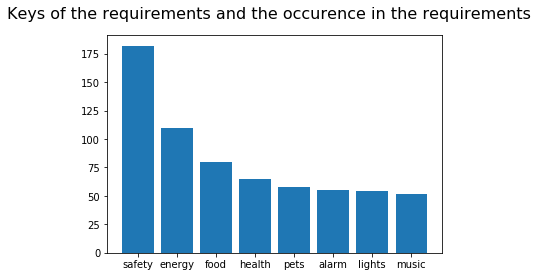

Total amount of keys: 5232
Keys per Requirement: min: 0, avg: 1, max: 11


In [6]:
x = list(re_list.tags.keys())[:8]
y = list(re_list.tags.values())[:8]
plot.bar(x, y)
plot.suptitle("Keys of the requirements and the occurence in the requirements", fontsize=16)
plot.show()
print("Total amount of keys: %d" % sum(re_list.tagNum))
print("Keys per Requirement: min: %d, avg: %d, max: %d" % (min(re_list.tagNum), sum(re_list.tagNum)/len(re_list.tagNum), max(re_list.tagNum)))

In [7]:
# Prepare Dataset for LDA

stemsList = []
for requirement in re_list:
    stemsList.append(requirement.stems)

# Bag of Words on the Data set
dictionary = gensim.corpora.Dictionary(stemsList)

# Filter out:
# less than 15 documents (absolute number) or
# more than 0.5 documents (fraction of total corpus size, not absolute number).
# after the above two steps, keep only the first 100000 most frequent tokens.
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# Gensim doc2bow
bow_corpus = [dictionary.doc2bow(reqirement) for reqirement in stemsList]
bow_doc_2965 = bow_corpus[2965]

for i in range(len(bow_doc_2965)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_2965[i][0], 
                                               dictionary[bow_doc_2965[i][0]], 
bow_doc_2965[i][1]))

Word 14 ("hous") appears 1 time.
Word 16 ("occup") appears 1 time.
Word 78 ("time") appears 1 time.
Word 128 ("notifi") appears 1 time.
Word 164 ("potenti") appears 1 time.
Word 210 ("avoid") appears 1 time.
Word 218 ("without") appears 1 time.
Word 223 ("enjoy") appears 1 time.


In [10]:
# Running LDA using Bag of Words
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)
# For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} Words: {}'.format(idx, topic))

Topic: 0 Words: 0.040*"owner" + 0.037*"food" + 0.036*"occup" + 0.023*"get" + 0.023*"need" + 0.020*"water" + 0.018*"run" + 0.015*"smart" + 0.014*"hous" + 0.014*"low"
Topic: 1 Words: 0.045*"occup" + 0.033*"light" + 0.028*"owner" + 0.026*"energi" + 0.026*"hous" + 0.025*"temperatur" + 0.019*"know" + 0.016*"sensor" + 0.013*"save" + 0.013*"smart"
Topic: 2 Words: 0.044*"owner" + 0.038*"music" + 0.037*"occup" + 0.026*"room" + 0.025*"lock" + 0.022*"door" + 0.022*"automat" + 0.020*"dog" + 0.019*"hous" + 0.018*"play"
Topic: 3 Words: 0.051*"turn" + 0.051*"occup" + 0.027*"owner" + 0.026*"smart" + 0.024*"water" + 0.019*"automat" + 0.017*"time" + 0.017*"light" + 0.014*"save" + 0.014*"get"
Topic: 4 Words: 0.061*"owner" + 0.040*"smart" + 0.035*"energi" + 0.032*"save" + 0.021*"occup" + 0.021*"pet" + 0.020*"automat" + 0.017*"room" + 0.016*"open" + 0.016*"use"
Topic: 5 Words: 0.042*"smart" + 0.035*"parent" + 0.035*"occup" + 0.033*"door" + 0.026*"owner" + 0.025*"know" + 0.021*"alert" + 0.020*"hous" + 0.017

In [9]:
# TF-IDF
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

# Running LDA using TF-IDF
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
# For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.022*"energi" + 0.018*"save" + 0.016*"light" + 0.015*"use" + 0.014*"occup" + 0.014*"owner" + 0.014*"room" + 0.014*"electr" + 0.013*"turn" + 0.011*"smart"
Topic: 1 Word: 0.014*"smart" + 0.012*"owner" + 0.012*"occup" + 0.012*"tv" + 0.011*"safe" + 0.011*"parent" + 0.011*"lock" + 0.011*"night" + 0.010*"door" + 0.010*"automat"
Topic: 2 Word: 0.018*"owner" + 0.017*"kid" + 0.016*"alert" + 0.013*"go" + 0.012*"dog" + 0.012*"level" + 0.012*"pet" + 0.012*"smart" + 0.012*"parent" + 0.011*"occup"
Topic: 3 Word: 0.023*"shower" + 0.021*"music" + 0.020*"temperatur" + 0.014*"occup" + 0.012*"room" + 0.012*"know" + 0.012*"warm" + 0.011*"owner" + 0.010*"turn" + 0.010*"work"
Topic: 4 Word: 0.027*"pet" + 0.026*"water" + 0.020*"owner" + 0.017*"smart" + 0.016*"fire" + 0.014*"hous" + 0.013*"plant" + 0.013*"alert" + 0.013*"occup" + 0.012*"system"
Topic: 5 Word: 0.025*"light" + 0.020*"turn" + 0.019*"occup" + 0.016*"automat" + 0.015*"save" + 0.014*"control" + 0.013*"night" + 0.013*"smart" + 0.012*